### Train Model Experiments NB 
This notebook contains the code to split the images and load them into train and validate sets.  The notebook also has the definition for the way the data should be loaded for each of six computer vision model types.  The notebook uses the concept of experiments to organize the fit/validate activities and allow for hyperparameter searching and logging results.  

Scroll down to the head "Experiments" and add your experiment as a new cell underneath the heading, modify the experiment meta data and run the cell.  



In [2]:
# import the libraries for training, testing, validation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils  # will decode predictions out of the model into a 4 dim array of N (image num), imageID, label, probability result[0] would be the set of results for image one
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img  # will load img and reshape, usage is load_img(image_name_loc, target_size=input_shape)
from tensorflow.keras.utils import plot_model  # Note: usage syntax is plot_model(instantied_model, to_file='', show_shapes=True)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds  # For loading datasets from GCS

# import all model architectures
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.applications import InceptionV3


import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time
import math


2025-03-20 16:59:13.995418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 16:59:15.026394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-03-20 16:59:15.026519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

In [3]:
# define a dictionary for model config and experiment tracking.... 
# define global variables
gcs_bucket = 'nabirds_filtered'  
dataset_path = 'images'  # Relative path within the bucket
default_batch_size = 32
default_image_size = (224, 224)

model_input_variables = {
    "MobileNetV2": {
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
     "MobileNetV3Large": { #MobileNetV3 Large will be used to compare accuracy loss with small, prob not a candidate for rasp pi running
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
    "MobileNetV3Small":{ 
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
    "EfficientNetB0": {
        "input_shape": (224, 224, 3),
        "batch_size": 32,
    },
    "InceptionV3": {
        "input_shape": (299, 299, 3),  # InceptionV3 typically uses 299x299
        "batch_size": 32,
    },
    "EfficientNetB7":{
        "input_shape": (600, 600, 3),  # big values!
        "batch_size": 16, # this is a larger model and the norm seems to be smaller batch sizes for reduced memory use
    }
}

models_list = list(model_input_variables.keys())

In [4]:
def write_results_to_file(filename, experiment, start_time, end_time, model_name, epochs, 
                          training_accuracy, validate_accuracy, training_loss, validate_loss,
                          num_stages, stage1, stage2):
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    batch_size = str(model_input_variables[model_name]['batch_size'])
    input_shape = str(model_input_variables[model_name]['input_shape']).replace(',','x')
    stage1 = f"stage1 epochs:{stage1['epochs']} trainable: {stage1['base_trainable']} trainable layers: {stage1['trainable_layers']} learning rate: {stage1['learning_rate']}"
    stage2 = f"stage2 epochs:{stage2['epochs']} trainable: {stage2['base_trainable']} trainable layers: {stage2['trainable_layers']} learning rate: {stage2['learning_rate']}"
    line = f'{experiment},{start_time_str},{end_time_str},{model_name},{batch_size},{epochs},{input_shape},{training_accuracy},' \
           f'{validate_accuracy},{training_loss},{validate_loss},{num_stages},{stage1},{stage2}\n'
    if not os.path.exists(filename):      # Check if the file exists, and add a header if it's new
        header = 'experiment,start_time,end_time,model_name,batch_size,epochs,input_shape,training_accuracy,validate_accuracy,training_loss,validate_loss,num_stages,stage1,stage2\n'
        with open(filename, "w") as f:
            f.write(header + line)
    else:
        with open(filename, "a") as f: # append to existing file
            f.write(line)
    print(f'experiment tracking updated')
    return

In [5]:
def load_images_gcs(bucket_name, dataset_path, model_image_size, model_batch_size):
    dataset = None
    gcs_dataset_path = f"gs://{bucket_name}/{dataset_path}"
    try:
        dataset = keras.utils.image_dataset_from_directory(gcs_dataset_path, image_size=model_image_size,
            batch_size=model_batch_size, label_mode='categorical',)  # categorical is for softmax layer
    except Exception as e:
        print(f'error loading dataset from gcs: {e}')    
    return dataset

In [6]:
# split into its own cell so we do not have to repeat this long operation, takes 10 minutes....
# need to run this each time for different image and batch sizes
def load_images(image_size=default_image_size, batch_size=default_batch_size):
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start loading images time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'Loading with image size of {image_size} and batch size of {batch_size}')

    train_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'train'), image_size, batch_size)
    validate_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'test'), image_size, batch_size)

    if train_dataset is None or validate_dataset is None:
        print(f'dataset loading failed.')
    return train_dataset, validate_dataset

In [7]:
def plot_training_results(acc, validate_acc, loss, validate_loss):
    epochs_plt = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_plt, acc, 'b', label='Training accuracy')
    plt.plot(epochs_plt, validate_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_plt, loss, 'b', label='Training loss')
    plt.plot(epochs_plt, validate_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

In [8]:
# lock and unlock layers, make this bullet proof so I don't have to think about the experiments too much
def lock_unlock_layers(model, train_last_x_layers):
    train_last_x_layers = 0 if train_last_x_layers == None else train_last_x_layers
    fine_tune_at = len(model.layers) - abs(train_last_x_layers)                        
    fine_tune_at = 0 if fine_tune_at < 0 else fine_tune_at
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True
    return model

In [34]:
def run_model_experiment(experiment_name, model_name, stages, stage1, stage2, train_dataset, validate_dataset, num_classes):
    stage1_learning = stage1["learning_rate"]
    stage1_epochs = stage1["epochs"]
    stage1_base_trainable = stage1['base_trainable']
    stage1_trainable_layers = stage1['trainable_layers']
    stage2_learning = stage2["learning_rate"]
    stage2_epochs = stage2["epochs"]
    stage2_base_trainable = stage2['base_trainable']
    stage2_trainable_layers = stage2['trainable_layers']
    
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start time training and validation: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'building model: {model_name} with {stages} stage(s)')
    print(f'stage1... ')
    print(f'epochs: {stage1_epochs}')
    print(f'learning rate of {stage1_learning}')
    print(f'trainable: {stage1_base_trainable}')
    print(f'trainable_layers: {stage1_trainable_layers}')
    
     # load each mode type and modify head for softmax replacement
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Large':
        base_model = MobileNetV2Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Small':
        base_model = MobileNetV2Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        print(f'unknown model {model_name} inf run_model_experiment case statement')

    #####  setup stage 1 of X #####
    base_model.trainable = stage1_base_trainable  # true unlocks the entire model
    if stage1_base_trainable is False and stage1_trainable_layers != None:  # false a number unlocks the last x layers
        base_model = lock_unlock_layers(model=base_model, train_last_x_layers=stage1_trainable_layers)
    x = base_model.output  # start adding custom layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  
    predictions = Dense(num_classes, activation='softmax')(x)

    # create the model with rescaling layer, this will automatically normalize the images within the model, bulletproofs feeder code
    # normalize pixel values to [0, 1], not sure if this was done in the old mobilenetv2 model
    inputs = base_model.input
    rescaled_inputs = tf.keras.layers.Rescaling(1./255)(inputs)  
    x = base_model(rescaled_inputs) # pass rescaled input through the base model
    model = Model(inputs=inputs, outputs=predictions) # use original inputs, this is weird, but how it was done in tutorial...

    # compile and train model, epoch zero is starting place for first stage, categorical crossentropy is for multi-class classification
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage1_learning), loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history_phase1 = model.fit(train_dataset, epochs=stage1_epochs, initial_epoch=0, validation_data=validate_dataset)  

    ##### setup stage 2 if requested
    combined_history = {}
    if stages == 2:
        model = lock_unlock_layers(model=model, train_last_x_layers=stage2_trainable_layers)
        # Recompile the model and continue from phase1, last epoch + 1 to move to next available 
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage2_learning), loss='categorical_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_phase2 = model.fit(train_dataset, epochs=stage1_epochs + stage2_epochs, initial_epoch=stage1_epochs, validation_data=validate_dataset)   

        for key in history_phase1.history:  # combine history
            try:
                combined_history[key] = history_phase1.history[key] + history_phase2.history[key]
            except:
                print(f'history1 key {key} not found in history2 ')
        for key2 in history_phase2.history:
            if key2 not in history_phase1.history:
                combined_history[key2] = history_phase2.history[key2]
    else:
        combined_history = history_phase1  # if one state take stage 1 hist    
    print(combined_history.keys())
                
    #### process results and save model
    # record training time
    end_time = time.time()
    end_time_datetime = datetime.datetime.fromtimestamp(end_time)
    print(f'End time training and validation: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

    total_epochs = stage1_epochs + stage2_epochs
    model_filename = experiment_name + model_name
    model.save(f'{model_filename}.h5')  # save the model

    # write_results_to_file
    acc = combined_history.history['accuracy']
    validate_acc = combined_history.history['val_accuracy']
    loss = combined_history.history['loss']
    validate_loss = combined_history.history['val_loss']

    write_results_to_file('experiment_log.csv', experiment_name, start_time_datetime, end_time_datetime, model_name, total_epochs, 
                          acc[-1], validate_acc[-1], loss[-1], validate_loss[-1], stages, stage1, stage2)
    plot_training_results(acc, validate_acc, loss, validate_loss) 
    return acc, validate_acc, loss, validate_loss

In [10]:
# the experiments dictionary drives the model types and training parameters 
# loop over each model type, stages, and write out results of experiment to a file, save the model
def run_experiments(experiments, train_dataset, validate_dataset, num_classes):
    for exper in list(experiments.keys()):
        stages = experiments[exper]['number_of_stages']
        stage1 = experiments[exper]['stage1']
        stage2 = experiments[exper]['stage2']
        
        for model_num in experiments[exper]['model_types']:
            model_name = models_list[model_num]
            acc, validate_acc, loss, validate_loss = run_model_experiment(exper, model_name, stages, stage1, stage2, train_dataset, validate_dataset, num_classes)
    return

In [12]:
# load the default data 224x224x3 ,batch size 32 data set.  do not loop over this code unless its an exception. 
# takes about 10 minutes, note this will output warning/errors since this NB is not using a GPU
# request a different load for a different model size, copy and paste code and change parameters
default_train_dataset, default_validate_dataset = load_images()
num_classes = len(default_train_dataset.class_names) # get class count, same no mater how the data is loaded given the same data set

Start loading images time: 2025-03-20 17:00:09
Loading with image size of (224, 224) and batch size of 32
Found 2455 files belonging to 27 classes.


2025-03-20 17:05:04.434901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-20 17:05:04.809222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-20 17:05:04.813702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-20 17:05:04.820895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Found 621 files belonging to 27 classes.


### Experiments
Keep the experiments here modify the commented out code below and make that a new call.  The output include accuracy, precision, and recall for training and validate.  quick primer:  

Accuracy: overall proportion of correct predictions (both true positives and true negatives) out of all predictions made.
Formula: (True Positives + True Negatives) / (Total Predictions)

Precision: measures the proportion of true positive predictions out of all positive predictions made by the model.
Formula: True Positives / (True Positives + False Positives)

Recall (also known as Sensitivity): measures the proportion of actual positive instances that the model correctly identified.
Formula: True Positives / (True Positives + False Negatives)


In [11]:
### Available Models
print(f'Available models: {models_list}')
print(f'EfficientNetB0: {model_input_variables["EfficientNetB0"]}')
print(f'MobileNetV2: {model_input_variables["MobileNetV2"]}')
print(f'MobileNetV3Large: {model_input_variables["MobileNetV3Large"]}')
print(f'MobileNetV3Small: {model_input_variables["MobileNetV3Small"]}')
print(f'InceptionV3: {model_input_variables["InceptionV3"]}')
print(f'EfficientNetB7: {model_input_variables["EfficientNetB7"]}')

Available models: ['MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'EfficientNetB0', 'InceptionV3', 'EfficientNetB7']
EfficientNetB0: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV2: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Large: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Small: {'input_shape': (224, 224, 3), 'batch_size': 32}
InceptionV3: {'input_shape': (299, 299, 3), 'batch_size': 32}
EfficientNetB7: {'input_shape': (600, 600, 3), 'batch_size': 16}


In [18]:
#### Sample Experiment, MobileNetV2 20 Epochs
# models_list = list(model_input_variables.keys())
# base_experiments_dict = {
#     'sample MobileNetV2 20 Epochs': { 
#         # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
#         'model_types': [0], # mobilenetv2 only
#         'number_of_stages': 1, 
#         'stage1': {'epochs': 20, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
#         'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0}
#         # 'stage2': {'epochs': 2, 'trainable': True, 'trainable_layers': -2, 'learning_rate': 0.00001}
#     }
# }

# run_experiments(base_experiments_dict, default_train_dataset, default_validate_dataset, num_classes)

In [33]:

#### Multi Model Code Experiment GPU, MobileNetV2 50 Epochs, transfer learning, all layers traininable, learing rate 0.0001
# converges quickly on training data (epoch 9 100%), but not validation data, indicates overfitting on the smaller training size
models_list = list(model_input_variables.keys())
mobilenet_all_versions_experiment_dict = {
    'MobileNetV2 V3Large V3Small GPU 2 stages 5 & 3 Epochs': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [0, 1, 2], # mobilenetv2, mobilenetv3large, mobilenetv3small 
        'number_of_stages': 2, 
        'stage1': {'epochs': 5, 'base_trainable': False, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 3, 'base_trainable': False, 'trainable_layers': -2, 'learning_rate': 0.00001}
    }
}

run_experiments(mobilenet_all_versions_experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-03-20 20:26:38
building model: MobileNetV2 with 2 stage(s)
stage1... 
epochs: 5
learning rate of 0.0001
trainable: False
trainable_layers: None
Epoch 1/5
77/77 [==============================] - 76s 876ms/step - loss: 3.3422 - accuracy: 0.0582 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - val_loss: 3.2652 - val_accuracy: 0.0709 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 2/5
77/77 [==============================] - 70s 827ms/step - loss: 3.1100 - accuracy: 0.1161 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - val_loss: 3.2112 - val_accuracy: 0.0789 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 3/5
77/77 [==============================] - 70s 831ms/step - loss: 2.9708 - accuracy: 0.1499 - precision_12: 1.0000 - recall_12: 8.1466e-04 - val_loss: 3.1661 - val_accuracy: 0.0950 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 4/5
77/77 [==============================] - 71s 839ms/st

AttributeError: 'dict' object has no attribute 'history'

### Recorded Experiments

#### Base Experiment GPU, MobileNetV2 50 Epochs, transfer learning, all layers traininable, learing rate 0.0001
- converges quickly on training data (epoch 9 100%), but not validation data, indicates overfitting on the smaller training size
- code:  
models_list = list(model_input_variables.keys())
base_experiments_dict = {
    'base MobileNetV2 GPU 50 Epochs': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [0], # mobilenetv2 only
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0}
        # 'stage2': {'epochs': 2, 'trainable': True, 'trainable_layers': -2, 'learning_rate': 0.00001}
    }
}

run_experiments(base_experiments_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-03-20 17:27:55
building model: MobileNetV2 with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/50
77/77 [==============================] - 115s 1s/step - loss: 2.0085 - accuracy: 0.4864 - precision_1: 0.9201 - recall_1: 0.1735 - val_loss: 2.9151 - val_accuracy: 0.2029 - val_precision_1: 0.3445 - val_recall_1: 0.0660
Epoch 2/50
77/77 [==============================] - 82s 992ms/step - loss: 0.4630 - accuracy: 0.8872 - precision_1: 0.9625 - recall_1: 0.7841 - val_loss: 2.2938 - val_accuracy: 0.3607 - val_precision_1: 0.5084 - val_recall_1: 0.2432
Epoch 3/50
77/77 [==============================] - 72s 858ms/step - loss: 0.1601 - accuracy: 0.9703 - precision_1: 0.9868 - recall_1: 0.9426 - val_loss: 1.8896 - val_accuracy: 0.4557 - val_precision_1: 0.5802 - val_recall_1: 0.3784
Epoch 4/50
77/77 [==============================] - 72s 856ms/step - loss: 0.0658 - accuracy: 0.9919 - precision_1: 0.9930 - recall_1: 0.9878 - val_loss: 1.4896 - val_accuracy: 0.5733 - val_precision_1: 0.6820 - val_recall_1: 0.5008
Epoch 5/50
77/77 [==============================] - 72s 858ms/step - loss: 0.0323 - accuracy: 0.9980 - precision_1: 0.9992 - recall_1: 0.9963 - val_loss: 1.3092 - val_accuracy: 0.6361 - val_precision_1: 0.7180 - val_recall_1: 0.5781
Epoch 6/50
77/77 [==============================] - 71s 850ms/step - loss: 0.0168 - accuracy: 0.9992 - precision_1: 0.9992 - recall_1: 0.9992 - val_loss: 1.0884 - val_accuracy: 0.6892 - val_precision_1: 0.7593 - val_recall_1: 0.6248
Epoch 7/50
77/77 [==============================] - 71s 850ms/step - loss: 0.0109 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.9342 - val_accuracy: 0.7375 - val_precision_1: 0.7874 - val_recall_1: 0.6860
Epoch 8/50
77/77 [==============================] - 71s 848ms/step - loss: 0.0079 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.7539 - val_accuracy: 0.7907 - val_precision_1: 0.8357 - val_recall_1: 0.7536
Epoch 9/50
77/77 [==============================] - 71s 845ms/step - loss: 0.0062 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.7082 - val_accuracy: 0.7923 - val_precision_1: 0.8442 - val_recall_1: 0.7681
Epoch 10/50
77/77 [==============================] - 71s 846ms/step - loss: 0.0050 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6735 - val_accuracy: 0.7939 - val_precision_1: 0.8427 - val_recall_1: 0.7762
Epoch 11/50
77/77 [==============================] - 73s 867ms/step - loss: 0.0043 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6391 - val_accuracy: 0.8052 - val_precision_1: 0.8467 - val_recall_1: 0.7826
Epoch 12/50
77/77 [==============================] - 73s 872ms/step - loss: 0.0036 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.5580 - val_accuracy: 0.8277 - val_precision_1: 0.8631 - val_recall_1: 0.8019
Epoch 13/50
77/77 [==============================] - 74s 866ms/step - loss: 0.0028 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.5341 - val_accuracy: 0.8599 - val_precision_1: 0.8808 - val_recall_1: 0.8213
Epoch 14/50
77/77 [==============================] - 72s 861ms/step - loss: 0.0044 - accuracy: 0.9992 - precision_1: 0.9992 - recall_1: 0.9992 - val_loss: 0.5348 - val_accuracy: 0.8357 - val_precision_1: 0.8774 - val_recall_1: 0.8180
Epoch 15/50
77/77 [==============================] - 71s 834ms/step - loss: 0.0030 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.5497 - val_accuracy: 0.8390 - val_precision_1: 0.8652 - val_recall_1: 0.8164
Epoch 16/50
77/77 [==============================] - 70s 830ms/step - loss: 0.0021 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4987 - val_accuracy: 0.8502 - val_precision_1: 0.8799 - val_recall_1: 0.8261
Epoch 17/50
77/77 [==============================] - 71s 849ms/step - loss: 0.0014 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4711 - val_accuracy: 0.8567 - val_precision_1: 0.8840 - val_recall_1: 0.8341
Epoch 18/50
77/77 [==============================] - 70s 838ms/step - loss: 0.0014 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4781 - val_accuracy: 0.8486 - val_precision_1: 0.8790 - val_recall_1: 0.8309
Epoch 19/50
77/77 [==============================] - 71s 845ms/step - loss: 0.0015 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4648 - val_accuracy: 0.8519 - val_precision_1: 0.8739 - val_recall_1: 0.8374
Epoch 20/50
77/77 [==============================] - 70s 835ms/step - loss: 0.0014 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4556 - val_accuracy: 0.8615 - val_precision_1: 0.8826 - val_recall_1: 0.8470
Epoch 21/50
77/77 [==============================] - 71s 852ms/step - loss: 8.6894e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4476 - val_accuracy: 0.8631 - val_precision_1: 0.8817 - val_recall_1: 0.8519
Epoch 22/50
77/77 [==============================] - 72s 831ms/step - loss: 9.2006e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4344 - val_accuracy: 0.8696 - val_precision_1: 0.9008 - val_recall_1: 0.8631
Epoch 23/50
77/77 [==============================] - 70s 829ms/step - loss: 9.1071e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.4179 - val_accuracy: 0.8857 - val_precision_1: 0.9045 - val_recall_1: 0.8696
Epoch 24/50
77/77 [==============================] - 68s 812ms/step - loss: 0.0221 - accuracy: 0.9951 - precision_1: 0.9951 - recall_1: 0.9943 - val_loss: 0.6902 - val_accuracy: 0.8229 - val_precision_1: 0.8505 - val_recall_1: 0.7971
Epoch 25/50
77/77 [==============================] - 69s 824ms/step - loss: 0.0995 - accuracy: 0.9817 - precision_1: 0.9840 - recall_1: 0.9772 - val_loss: 0.9585 - val_accuracy: 0.7520 - val_precision_1: 0.8076 - val_recall_1: 0.7166
Epoch 26/50
77/77 [==============================] - 68s 813ms/step - loss: 0.1452 - accuracy: 0.9601 - precision_1: 0.9677 - recall_1: 0.9519 - val_loss: 1.1681 - val_accuracy: 0.7327 - val_precision_1: 0.7547 - val_recall_1: 0.7037
Epoch 27/50
77/77 [==============================] - 69s 822ms/step - loss: 0.0828 - accuracy: 0.9723 - precision_1: 0.9766 - recall_1: 0.9699 - val_loss: 1.1712 - val_accuracy: 0.7456 - val_precision_1: 0.7892 - val_recall_1: 0.7295
Epoch 28/50
77/77 [==============================] - 68s 811ms/step - loss: 0.0334 - accuracy: 0.9890 - precision_1: 0.9914 - recall_1: 0.9870 - val_loss: 0.9743 - val_accuracy: 0.7826 - val_precision_1: 0.8148 - val_recall_1: 0.7649
Epoch 29/50
77/77 [==============================] - 69s 821ms/step - loss: 0.0210 - accuracy: 0.9935 - precision_1: 0.9939 - recall_1: 0.9935 - val_loss: 0.9356 - val_accuracy: 0.7810 - val_precision_1: 0.8051 - val_recall_1: 0.7649
Epoch 30/50
77/77 [==============================] - 68s 811ms/step - loss: 0.0134 - accuracy: 0.9955 - precision_1: 0.9959 - recall_1: 0.9947 - val_loss: 0.9315 - val_accuracy: 0.7987 - val_precision_1: 0.8212 - val_recall_1: 0.7842
Epoch 31/50
77/77 [==============================] - 67s 802ms/step - loss: 0.0097 - accuracy: 0.9967 - precision_1: 0.9967 - recall_1: 0.9967 - val_loss: 0.7061 - val_accuracy: 0.8454 - val_precision_1: 0.8672 - val_recall_1: 0.8309
Epoch 32/50
77/77 [==============================] - 68s 809ms/step - loss: 0.0050 - accuracy: 0.9996 - precision_1: 0.9996 - recall_1: 0.9992 - val_loss: 0.7021 - val_accuracy: 0.8406 - val_precision_1: 0.8607 - val_recall_1: 0.8261
Epoch 33/50
77/77 [==============================] - 70s 830ms/step - loss: 0.0042 - accuracy: 0.9988 - precision_1: 0.9992 - recall_1: 0.9988 - val_loss: 0.7413 - val_accuracy: 0.8293 - val_precision_1: 0.8545 - val_recall_1: 0.8132
Epoch 34/50
77/77 [==============================] - 69s 822ms/step - loss: 0.0022 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6595 - val_accuracy: 0.8502 - val_precision_1: 0.8675 - val_recall_1: 0.8438
Epoch 35/50
77/77 [==============================] - 70s 838ms/step - loss: 9.6601e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6168 - val_accuracy: 0.8567 - val_precision_1: 0.8783 - val_recall_1: 0.8486
Epoch 36/50
77/77 [==============================] - 69s 818ms/step - loss: 0.0015 - accuracy: 0.9996 - precision_1: 0.9996 - recall_1: 0.9996 - val_loss: 0.6802 - val_accuracy: 0.8406 - val_precision_1: 0.8739 - val_recall_1: 0.8261
Epoch 37/50
77/77 [==============================] - 69s 822ms/step - loss: 0.0012 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 0.9996 - val_loss: 0.6318 - val_accuracy: 0.8519 - val_precision_1: 0.8706 - val_recall_1: 0.8454
Epoch 38/50
77/77 [==============================] - 69s 819ms/step - loss: 0.0029 - accuracy: 0.9992 - precision_1: 0.9992 - recall_1: 0.9992 - val_loss: 0.6583 - val_accuracy: 0.8567 - val_precision_1: 0.8698 - val_recall_1: 0.8390
Epoch 39/50
77/77 [==============================] - 69s 818ms/step - loss: 0.0012 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6229 - val_accuracy: 0.8599 - val_precision_1: 0.8783 - val_recall_1: 0.8486
Epoch 40/50
77/77 [==============================] - 69s 817ms/step - loss: 0.0020 - accuracy: 0.9996 - precision_1: 1.0000 - recall_1: 0.9992 - val_loss: 0.6576 - val_accuracy: 0.8599 - val_precision_1: 0.8727 - val_recall_1: 0.8502
Epoch 41/50
77/77 [==============================] - 68s 815ms/step - loss: 0.0111 - accuracy: 0.9967 - precision_1: 0.9967 - recall_1: 0.9967 - val_loss: 0.7444 - val_accuracy: 0.8325 - val_precision_1: 0.8552 - val_recall_1: 0.8180
Epoch 42/50
77/77 [==============================] - 67s 798ms/step - loss: 0.0035 - accuracy: 0.9988 - precision_1: 0.9988 - recall_1: 0.9988 - val_loss: 0.7295 - val_accuracy: 0.8502 - val_precision_1: 0.8739 - val_recall_1: 0.8374
Epoch 43/50
77/77 [==============================] - 69s 827ms/step - loss: 0.0191 - accuracy: 0.9939 - precision_1: 0.9943 - recall_1: 0.9939 - val_loss: 1.3661 - val_accuracy: 0.7504 - val_precision_1: 0.7640 - val_recall_1: 0.7456
Epoch 44/50
77/77 [==============================] - 67s 799ms/step - loss: 0.0217 - accuracy: 0.9939 - precision_1: 0.9939 - recall_1: 0.9939 - val_loss: 0.9899 - val_accuracy: 0.7923 - val_precision_1: 0.8148 - val_recall_1: 0.7794
Epoch 45/50
77/77 [==============================] - 67s 802ms/step - loss: 0.0330 - accuracy: 0.9914 - precision_1: 0.9918 - recall_1: 0.9898 - val_loss: 1.0763 - val_accuracy: 0.7810 - val_precision_1: 0.7947 - val_recall_1: 0.7729
Epoch 46/50
77/77 [==============================] - 67s 791ms/step - loss: 0.0839 - accuracy: 0.9760 - precision_1: 0.9787 - recall_1: 0.9735 - val_loss: 1.7851 - val_accuracy: 0.7134 - val_precision_1: 0.7487 - val_recall_1: 0.7053
Epoch 47/50
77/77 [==============================] - 67s 796ms/step - loss: 0.0468 - accuracy: 0.9866 - precision_1: 0.9865 - recall_1: 0.9853 - val_loss: 2.4792 - val_accuracy: 0.6425 - val_precision_1: 0.6578 - val_recall_1: 0.6345
Epoch 48/50
77/77 [==============================] - 67s 797ms/step - loss: 0.0279 - accuracy: 0.9898 - precision_1: 0.9906 - recall_1: 0.9894 - val_loss: 1.5020 - val_accuracy: 0.7262 - val_precision_1: 0.7513 - val_recall_1: 0.7101
Epoch 49/50
77/77 [==============================] - 67s 794ms/step - loss: 0.0075 - accuracy: 0.9971 - precision_1: 0.9980 - recall_1: 0.9971 - val_loss: 1.4184 - val_accuracy: 0.7617 - val_precision_1: 0.7815 - val_recall_1: 0.7488
Epoch 50/50
77/77 [==============================] - 68s 804ms/step - loss: 0.0098 - accuracy: 0.9963 - precision_1: 0.9963 - recall_1: 0.9959 - val_loss: 1.1954 - val_accuracy: 0.7520 - val_precision_1: 0.7722 - val_recall_1: 0.7424
End time training and validation: 2025-03-20 18:27:05
experiment tracking updated



Start time training and validation: 2025-03-20 17:27:55
building model: MobileNetV2 with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/50
77/77 [==============================] - 115s 1s/step - loss: 2.0085 - accuracy: 0.4864 - precision_1: 0.9201 - recall_1: 0.1735 - val_loss: 2.9151 - val_accuracy: 0.2029 - val_precision_1: 0.3445 - val_recall_1: 0.0660
Epoch 2/50
77/77 [==============================] - 82s 992ms/step - loss: 0.4630 - accuracy: 0.8872 - precision_1: 0.9625 - recall_1: 0.7841 - val_loss: 2.2938 - val_accuracy: 0.3607 - val_precision_1: 0.5084 - val_recall_1: 0.2432
Epoch 3/50
77/77 [==============================] - 72s 858ms/step - loss: 0.1601 - accuracy: 0.9703 - precision_1: 0.9868 - recall_1: 0.9426 - val_loss: 1.8896 - val_accuracy: 0.4557 - val_precision_1: 0.5802 - val_recall_1: 0.3784
Epoch 4/50
77/77 [==============================] - 72s 856ms/step - loss: 0.0658 - accuracy: 0.9919 - precision_1: 0.

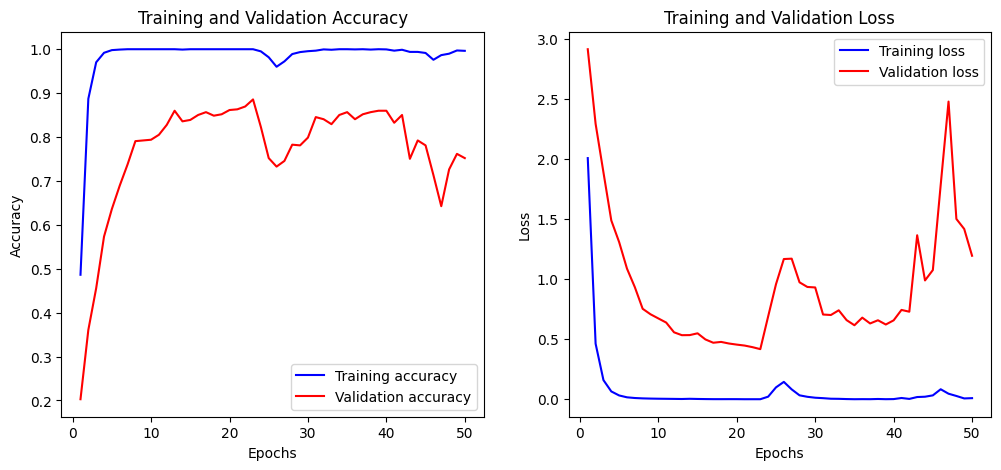

In [14]:
# #### Base Experiment GPU, MobileNetV2 50 Epochs, transfer learning, all layers traininable, learing rate 0.0001
# # converges quickly on training data (epoch 9 100%), but not validation data, indicates overfitting on the smaller training size
# models_list = list(model_input_variables.keys())
# base_experiments_dict = {
#     'base MobileNetV2 GPU 50 Epochs': { 
#         # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
#         'model_types': [0], # mobilenetv2 only
#         'number_of_stages': 1, 
#         'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
#         'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0}
#         # 'stage2': {'epochs': 2, 'trainable': True, 'trainable_layers': -2, 'learning_rate': 0.00001}
#     }
# }

# run_experiments(base_experiments_dict, default_train_dataset, default_validate_dataset, num_classes)